<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/PyTorch/Transformer/Tabular/TimeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

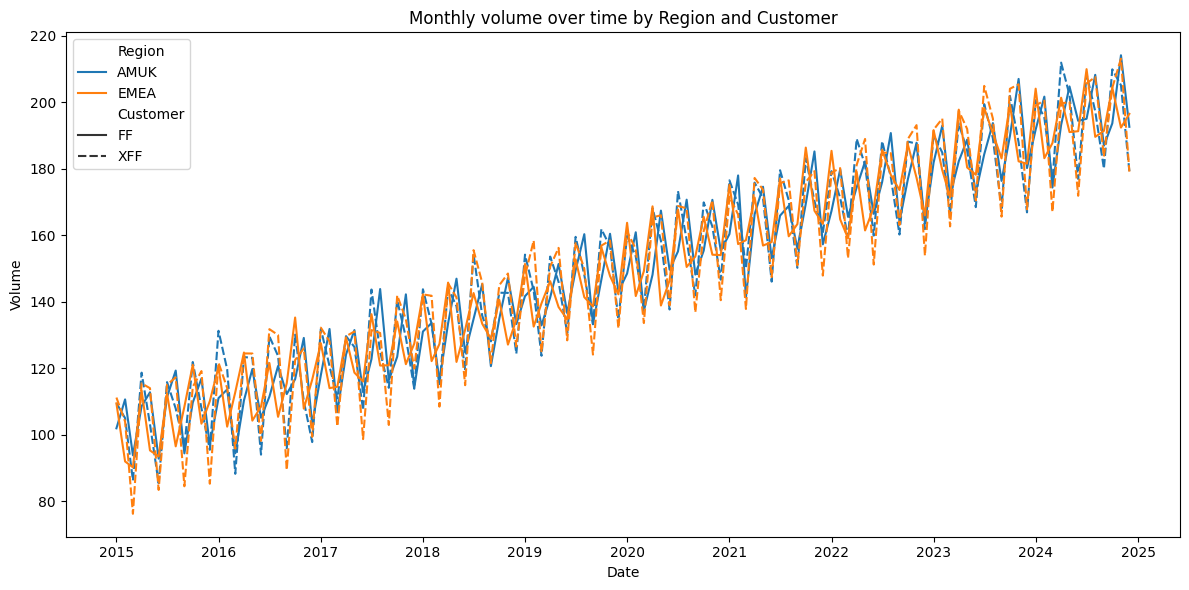

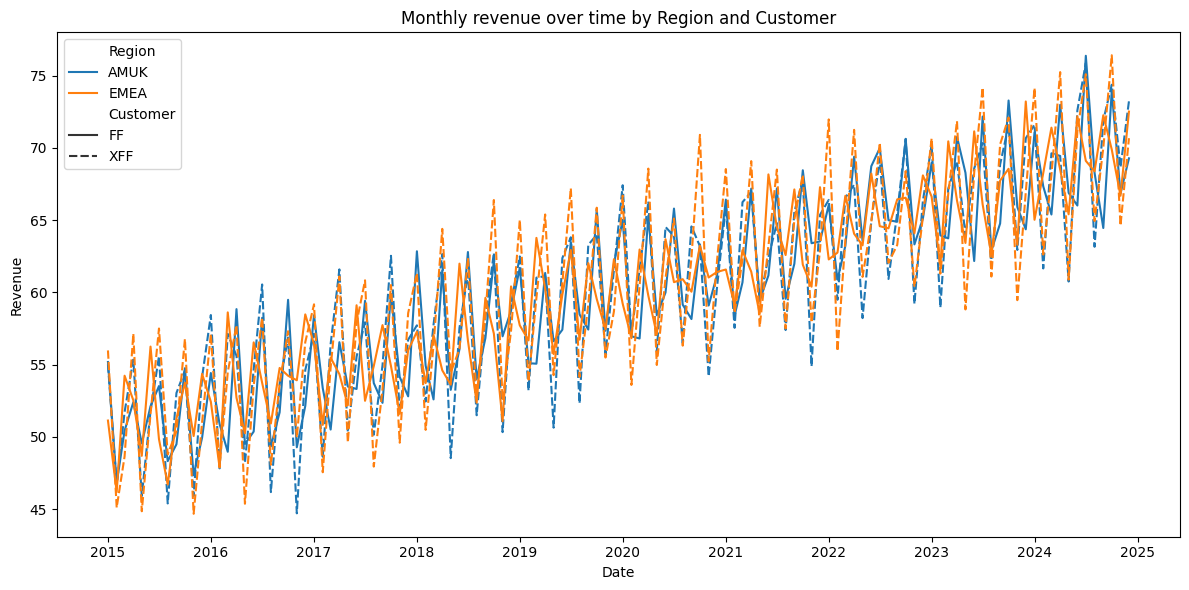

In [8]:
import numpy as np
np.random.seed(seed=42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

regions = ['AMUK', 'EMEA']
customers = ['FF', 'XFF']

seasonal_params = {
    ('AMUK', 'FF'): {'amp_vol': 12, 'amp_rev': 4, 'phase': 0},
    ('AMUK', 'XFF'): {'amp_vol': 18, 'amp_rev': 6, 'phase': np.pi/4},
    ('EMEA', 'FF'): {'amp_vol': 10, 'amp_rev': 3, 'phase': np.pi/2},
    ('EMEA', 'XFF'): {'amp_vol': 20, 'amp_rev': 7, 'phase': np.pi/6}
}

start_date = '2015-01-01'
years = 10
periods = years * 12
time_index = pd.date_range(start=start_date, periods=periods, freq='MS')

data = []
for region in regions:
    for customer in customers:

        trend_volume = np.linspace(start=100, stop=200, num=periods)
        trend_revenue = np.linspace(start=50, stop=70, num=periods)

        t = np.arange(periods)
        params = seasonal_params[(region, customer)]
        seasonality_volume = params['amp_vol']*np.sin(2*np.pi*t/3 + params['phase'])
        seasonality_revenue = params['amp_rev']*np.cos(2*np.pi*t/3 + params['phase'])

        noise_volume = np.random.normal(loc=0, scale=4, size=periods)
        noise_revenue = np.random.normal(loc=0, scale=1.5, size=periods)

        volume = trend_volume + seasonality_volume + noise_volume
        revenue = trend_revenue + seasonality_revenue + noise_revenue

        df_temp = pd.DataFrame({
            'Date': time_index,
            'Region': region,
            'Customer': customer,
            'Volume': volume,
            'Revenue': revenue
        })
        data.append(df_temp)

df = pd.concat(data, ignore_index=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Volume', hue='Region', style='Customer')
plt.title('Monthly volume over time by Region and Customer')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Revenue', hue='Region', style='Customer')
plt.title('Monthly revenue over time by Region and Customer')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

T = 1000
num_entities = 3
num_features = 2

data_dict = {}
for eid in range(num_entities):
    t = np.linspace(0, 100, T)
    f1 = np.sin(t / 5 + eid) + 0.1 * np.random.randn(T)
    f2 = np.cos(t / 7 + eid) + 0.1 * np.random.randn(T)
    data_dict[eid] = np.stack([f1, f2], axis=1)

data_dict

{0: array([[-0.0765127 ,  0.87576799],
        [ 0.22701714,  1.15407886],
        [ 0.21003928,  0.81589682],
        ...,
        [ 0.9730543 , -0.14715295],
        [ 0.82721587, -0.12586493],
        [ 0.80328767, -0.12444039]]),
 1: array([[ 0.86245742,  0.52030746],
        [ 0.71166298,  0.71256778],
        [ 1.01541365,  0.55924303],
        ...,
        [ 0.86152229, -0.95095153],
        [ 0.95050247, -0.87563827],
        [ 0.76681366, -0.78759677]]),
 2: array([[ 0.90032458, -0.5913432 ],
        [ 0.94378123, -0.28401772],
        [ 0.85348878, -0.41803798],
        ...,
        [ 0.00426563, -0.83925596],
        [ 0.10996014, -0.83784581],
        [-0.1812202 , -0.8404028 ]])}

In [ ]:
import torch
torch.manual_seed(seed=42)

class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict, input_window, output_window):
        self.series = []
        self.entity_ids = []
        self.input_window = input_window
        self.output_window = output_window

        for eid, data in data_dict.items():
            for i in range(len(data) - input_window - output_window):
                x = data[i : i + input_window]
                y = data[i + input_window : i + input_window + output_window]
                self.series.append((x, y))
                self.entity_ids.append(eid)

        self.num_entities = len(data_dict)

    def __len__(self):
        return len(self.series)

    def __getitem__(self, idx):
        x, y = self.series[idx]
        entity_id = self.entity_ids[idx]
        return (
            torch.tensor(data=x, dtype=torch.float32),
            torch.tensor(data=y, dtype=torch.float32),
            torch.tensor(data=entity_id, dtype=torch.long)
        )

input_window = 48
output_window = 24
ds_train = TimeSeriesDataset(data_dict=data_dict,
    input_window=input_window, output_window=output_window)
dl_train = torch.utils.data.DataLoader(dataset=ds_train,
    batch_size=32, shuffle=True)
len(dl_train.dataset)

2784

In [ ]:
import torch
torch.manual_seed(seed=42)

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TimeSeriesForecast(torch.nn.Module):
    def __init__(self, num_entities, feature_size, entity_emb_dim=8, d_model=64,
            nhead=8, num_layers=3, dropout=0.1):
        super().__init__()
        self.entity_embedding = torch.nn.Embedding(num_embeddings=num_entities,
            embedding_dim=entity_emb_dim)
        self.input_proj = torch.nn.Linear(in_features=feature_size + entity_emb_dim,
            out_features=d_model)
        self.pos_encoder = PositionalEncoding(d_model=d_model)
        self.transformer = torch.nn.TransformerEncoder(num_layers=num_layers,
            encoder_layer=torch.nn.TransformerEncoderLayer(
                d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
                dropout=dropout, batch_first=True))
        self.decoder = torch.nn.Linear(in_features=d_model,
            out_features=feature_size * output_window)
        self.output_window = output_window
        self.feature_size = feature_size

    def forward(self, src, entity_id):
        B, T, F = src.shape
        entity_emb = self.entity_embedding(entity_id)
        entity_emb_expanded = entity_emb.unsqueeze(1).expand(-1, T, -1)
        src = torch.cat([src, entity_emb_expanded], dim=-1)

        src = self.input_proj(src)
        src = self.pos_encoder(src)
        enc_output = self.transformer(src)
        out = self.decoder(enc_output[:, -1, :])
        out = out.view(B, self.output_window, self.feature_size)
        return out

model = TimeSeriesForecast(num_entities=num_entities, feature_size=num_features)

In [ ]:
import torch
torch.manual_seed(seed=42)

def train_model(model, dl_train, epochs=20, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y, eid in dl_train:
            optimizer.zero_grad()
            preds = model(x, eid)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dl_train)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

train_model(model, dl_train, epochs=20)

Epoch 1/20, Loss: 0.1973
Epoch 2/20, Loss: 0.0341
Epoch 3/20, Loss: 0.0236
Epoch 4/20, Loss: 0.0199
Epoch 5/20, Loss: 0.0190
Epoch 6/20, Loss: 0.0171
Epoch 7/20, Loss: 0.0163
Epoch 8/20, Loss: 0.0161
Epoch 9/20, Loss: 0.0154
Epoch 10/20, Loss: 0.0154
Epoch 11/20, Loss: 0.0143
Epoch 12/20, Loss: 0.0141
Epoch 13/20, Loss: 0.0141
Epoch 14/20, Loss: 0.0137
Epoch 15/20, Loss: 0.0135
Epoch 16/20, Loss: 0.0133
Epoch 17/20, Loss: 0.0131
Epoch 18/20, Loss: 0.0133
Epoch 19/20, Loss: 0.0130
Epoch 20/20, Loss: 0.0127


In [ ]:
import torch
torch.manual_seed(seed=42)

def forecast(model, src, entity_id, pred_len):
    model.eval()
    with torch.no_grad():
        src = src.unsqueeze(0)
        entity_id = torch.tensor(data=[entity_id])
        preds = model(src, entity_id)
        return preds.squeeze(0).numpy()

i, id = 888, 1
x = torch.tensor(data=data_dict[id][i : i + input_window],
    dtype=torch.float32)
y = data_dict[id][i + input_window : i + input_window + output_window]
y_pred = forecast(model, x, entity_id=id, pred_len=output_window)
print("y:", y)
print("y_pred:", y_pred)

y: [[ 0.7378014  -0.17062459]
 [ 0.65562839 -0.24468778]
 [ 0.89521209 -0.2739831 ]
 [ 0.68381718 -0.14895508]
 [ 0.87311345 -0.14708252]
 [ 0.92700592 -0.19747057]
 [ 0.91405703 -0.38856502]
 [ 0.91661291 -0.38129252]
 [ 0.82505147 -0.4227525 ]
 [ 0.90593572 -0.35584178]
 [ 0.94643129 -0.48437101]
 [ 1.000572   -0.22627509]
 [ 0.82967447 -0.36167518]
 [ 0.76791075 -0.4530884 ]
 [ 0.79016893 -0.46903305]
 [ 0.91928953 -0.39238212]
 [ 1.03942509 -0.67764835]
 [ 0.88154492 -0.21819894]
 [ 1.03736087 -0.47095549]
 [ 0.88872913 -0.45829651]
 [ 1.11862327 -0.39913975]
 [ 1.0395548  -0.47683268]
 [ 1.05676926 -0.48334432]
 [ 0.98548474 -0.55166493]]
y_pred: [[ 0.79458326 -0.22347859]
 [ 0.8102378  -0.28484443]
 [ 0.8000269  -0.21767141]
 [ 0.8296937  -0.24198294]
 [ 0.85036206 -0.27875715]
 [ 0.82830435 -0.2864824 ]
 [ 0.8296084  -0.308783  ]
 [ 0.88359874 -0.3198858 ]
 [ 0.86437696 -0.31511402]
 [ 0.9145154  -0.29322132]
 [ 0.8847406  -0.38443005]
 [ 0.9229697  -0.3525533 ]
 [ 0.91900754 -0